# Conversion From a LIF network to DynapSim Network

In [19]:
# - Switch off warnings
from __future__ import annotations
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Typing
from typing import Callable, Dict, Tuple
import types

# - Numpy
import numpy as np
import copy
import seaborn as sns
from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    dynapsim_from_graph,
    dynapsim_from_config,
)

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

In [2]:
# - Network size
Nin = 12
N1 = 20
N2 = 8
N3 = 4
input_scale = 20.
dt = 1e-3

In [3]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N1), has_bias = False), # 30x20
    LIFODEJax((N1, N1), dt = dt, has_rec=True), # 40x40
    LinearJax((N1, N2), has_bias = False), # 30x20
    LIFODEJax((N2, N2), dt = dt, has_rec=True), # 40x40
    LinearJax((N2, N3), has_bias = False), # 30x20
    LIFODEJax((N3, N3), dt = dt, has_rec=True), # 40x40
)

print(modFFwd)

JaxSequential  with shape (12, 4) {
    LinearJax '0_LinearJax' with shape (12, 20)
    LIFODEJax '1_LIFODEJax' with shape (20, 20)
    LinearJax '2_LinearJax' with shape (20, 8)
    LIFODEJax '3_LIFODEJax' with shape (8, 8)
    LinearJax '4_LinearJax' with shape (8, 4)
    LIFODEJax '5_LIFODEJax' with shape (4, 4)
}


In [4]:
from rockpool.devices.dynapse import DynapseNeurons

In [5]:
from rockpool.graph.utils import bag_graph, find_recurrent_modules

mod_graph = modFFwd.as_graph()
nodes, modules = bag_graph(mod_graph)
rec_modules = find_recurrent_modules(mod_graph)

In [6]:
modules

[LinearWeights "LinearJax_'0_LinearJax'_4422168592" with 12 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11164948976" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11164948976" with 20 input nodes -> 20 output nodes,
 LinearWeights "LinearJax_'2_LinearJax'_11164949552" with 20 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11248168448" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11248168448" with 8 input nodes -> 8 output nodes,
 LinearWeights "LinearJax_'4_LinearJax'_11248164464" with 8 input nodes -> 4 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11248254304" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11248254304" with 4 input nodes -> 4 output nodes]

In [7]:
mod_se2 = dynapsim_from_graph(modFFwd.as_graph())
mod_se2

JaxSequential  with shape (12, 32) {
    LinearJax '0_LinearJax' with shape (12, 32)
    DynapSim '1_DynapSim' with shape (32, 32)
}

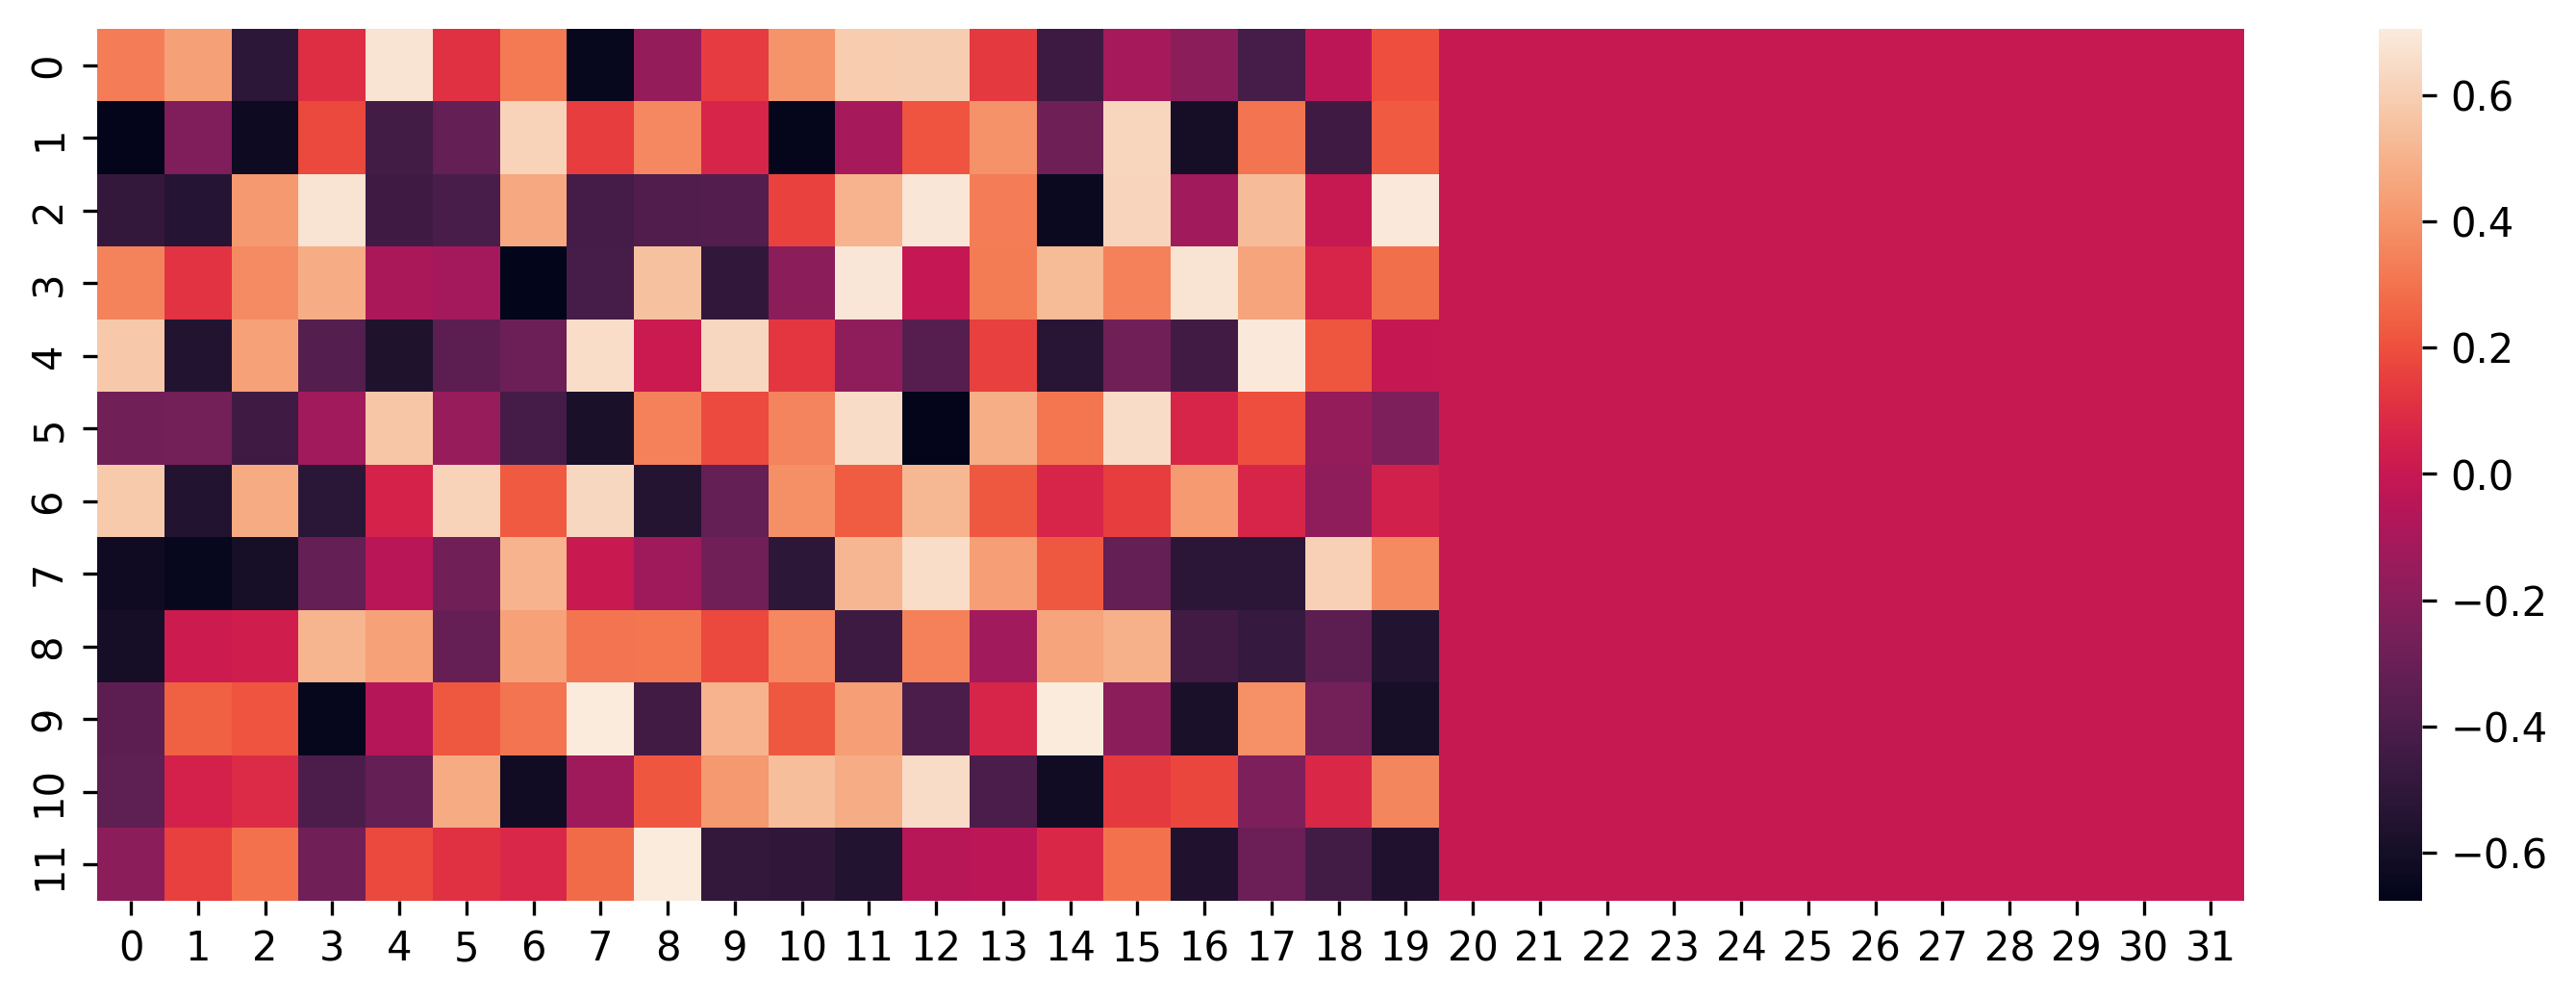

In [8]:
ax = sns.heatmap(mod_se2[0].weight)
plt.show()

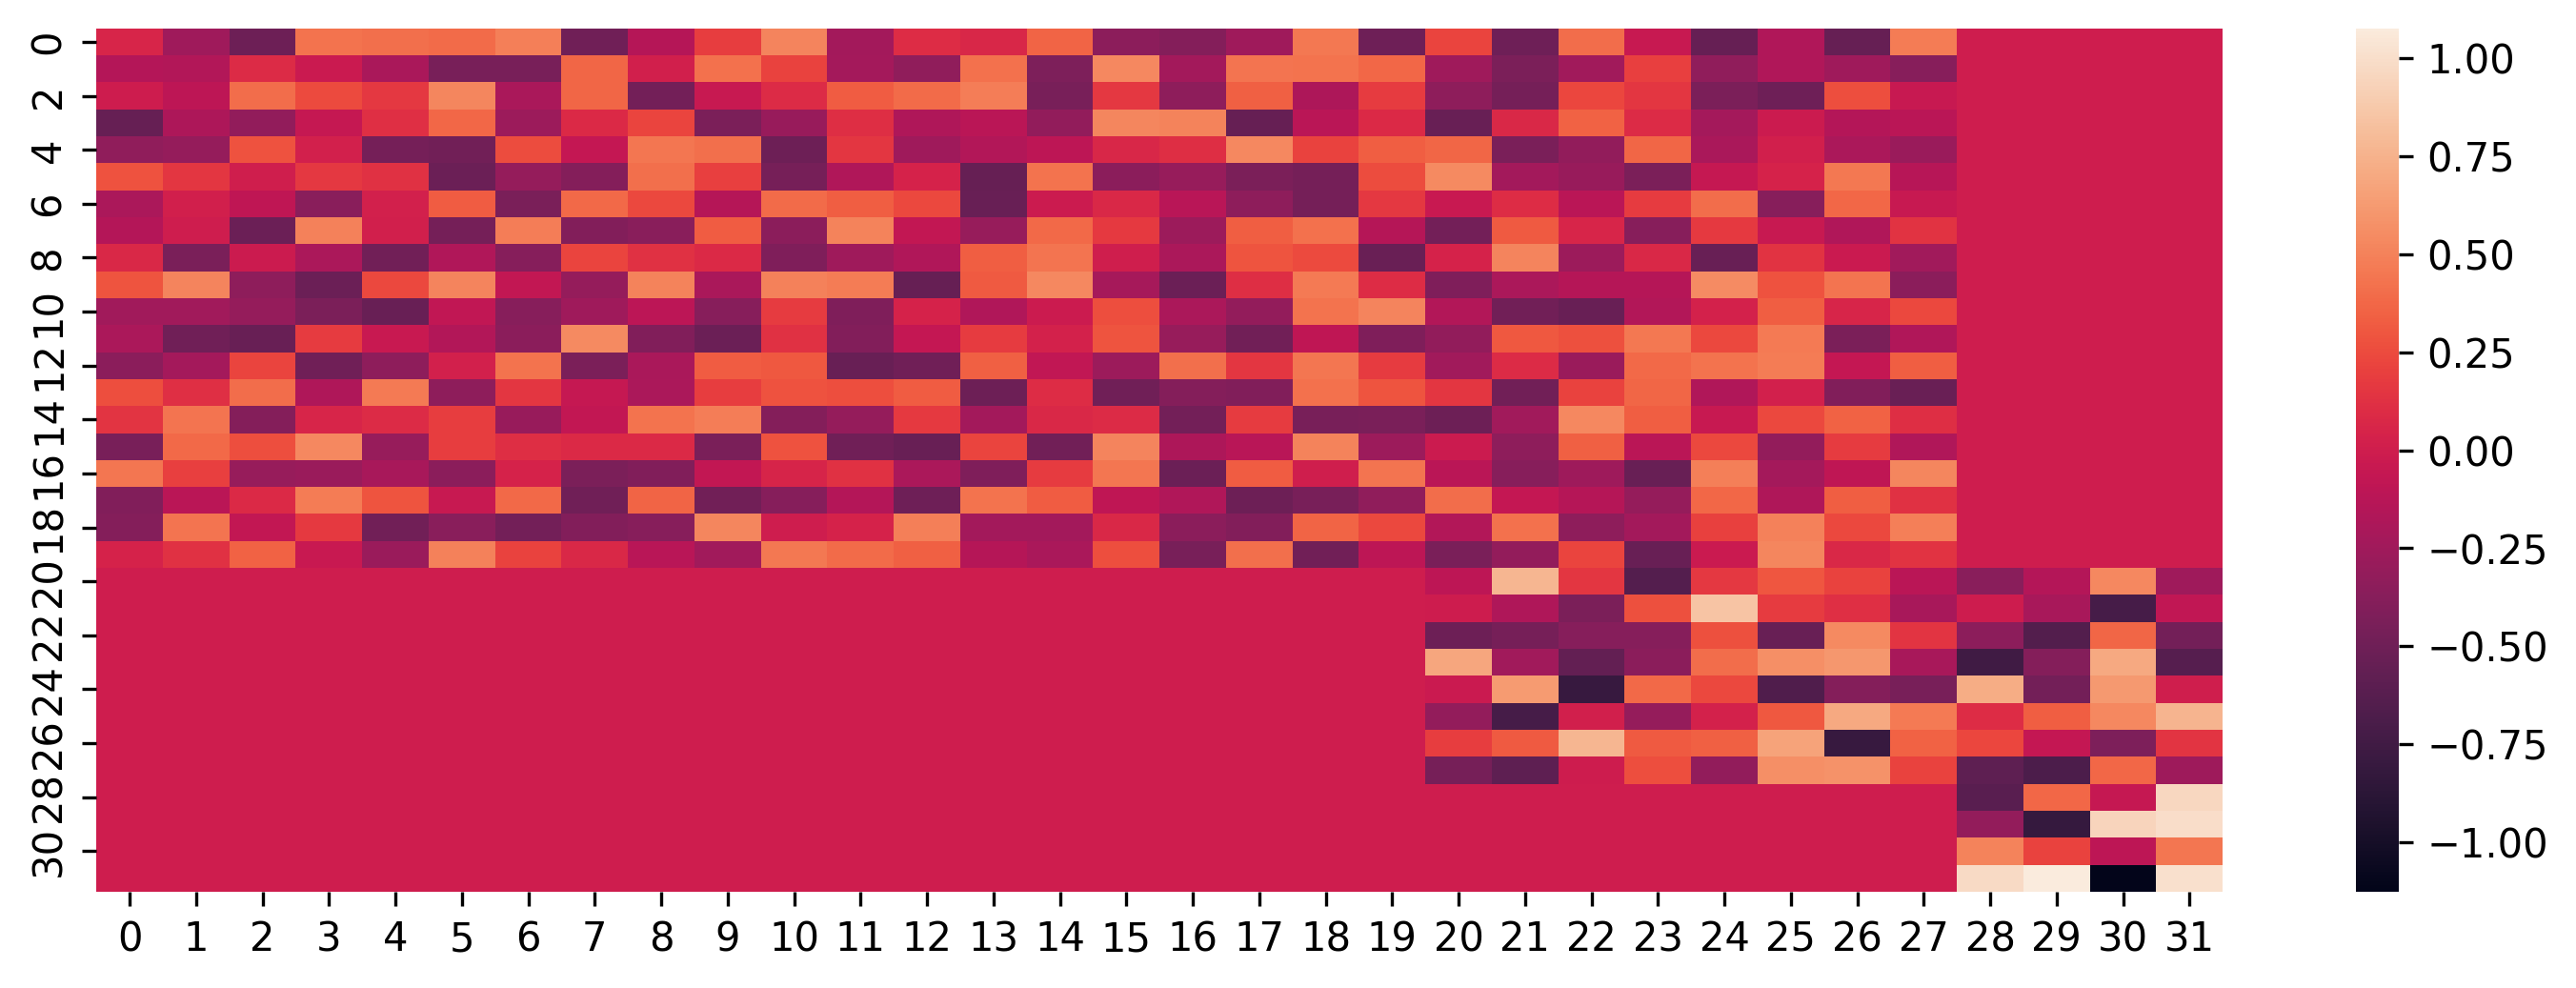

In [9]:
ax = sns.heatmap(mod_se2[1].w_rec)


In [15]:
spec = mapper(modFFwd.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__11248254208_transformed_SE_11491016512" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[ 0.33150408,  0.43629202, -0.50986813,  0.09654199,  0.67769816,
          0.10771397,  0.32122209, -0.64922536, -0.15844986,  0.1425469 ,
          0.39842341,  0.58928629,  0.5958252 ,  0.13653345, -0.45807021,
         -0.10516147, -0.19144465, -0.42123577, -0.03852565,  0.19790239,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.66810897, -0.23122803, -0.62740138,  0.17898369, -0.43240001,
         -0.31799763,  0.61535744,  0.14421535,  0.36484872,  0.0633145 ,
         -0.66250789, -0.10559328,  0.20925758,  0.3928694 , -0.28779074,
          0.62650197, -0.59522027,  0.30060802, -0.44426065,  0.22771167,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [16]:
spec.update(parameter_clustering(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11248254208_transformed_SE_11491016512" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[ 0.33150408,  0.43629202, -0.50986813,  0.09654199,  0.67769816,
          0.10771397,  0.32122209, -0.64922536, -0.15844986,  0.1425469 ,
          0.39842341,  0.58928629,  0.5958252 ,  0.13653345, -0.45807021,
         -0.10516147, -0.19144465, -0.42123577, -0.03852565,  0.19790239,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.66810897, -0.23122803, -0.62740138,  0.17898369, -0.43240001,
         -0.31799763,  0.61535744,  0.14421535,  0.36484872,  0.0633145 ,
         -0.66250789, -0.10559328,  0.20925758,  0.3928694 , -0.28779074,
          0.62650197, -0.59522027,  0.30060802, -0.44426065,  0.22771167,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [17]:
spec.update(autoencoder_quantization(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11248254208_transformed_SE_11491016512" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[ 9,  7, 13,  0, 15,  4, 12, 15,  8,  8, 14, 15, 15,  4,  7,  8,
           1, 11,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  3, 15, 12, 14,  6, 15,  1, 11,  4, 15,  1,  3, 12,  4, 15,
          15,  2,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15, 13, 13, 15, 13, 12, 13,  9, 13,  6,  1, 13, 15, 11, 15, 15,
           4, 15,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [13,  1,  9, 11,  1,  0, 15,  5,  7, 14,  8, 15,  0,  3,  7,  9,
          15, 13,  8, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15, 11, 11, 14, 15,  9,  3, 15,  0, 15,  8,  1, 12,  2, 15,  3,
          14, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 9,  2, 11,  4, 15,  1, 14, 15,  3,  9, 12, 15, 15, 13, 10, 15,
           0, 10,  2, 10,  0,  0,  0,  0, 

In [18]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11248254208_transformed_SE_11491016512" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[ 9,  7, 13,  0, 15,  4, 12, 15,  8,  8, 14, 15, 15,  4,  7,  8,
           1, 11,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  3, 15, 12, 14,  6, 15,  1, 11,  4, 15,  1,  3, 12,  4, 15,
          15,  2,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15, 13, 13, 15, 13, 12, 13,  9, 13,  6,  1, 13, 15, 11, 15, 15,
           4, 15,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [13,  1,  9, 11,  1,  0, 15,  5,  7, 14,  8, 15,  0,  3,  7,  9,
          15, 13,  8, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15, 11, 11, 14, 15,  9,  3, 15,  0, 15,  8,  1, 12,  2, 15,  3,
          14, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 9,  2, 11,  4, 15,  1, 14, 15,  3,  9, 12, 15, 15, 13, 10, 15,
           0, 10,  2, 10,  0,  0,  0,  0, 

In [21]:
mod_se2_reconstructed = dynapsim_from_config(spec['config'])

In [24]:
from rockpool.devices.dynapse.quantization import WeightHandler

In [23]:
mod_se2_reconstructed[0].weight

array([[ 0.31207103,  0.48434476, -0.47451147,  0.        ,  0.63695191,
         0.16244044,  0.31504759, -0.63695191, -0.15260715,  0.15260715,
         0.47748803,  0.63695191,  0.63695191,  0.16244044, -0.48434476,
        -0.15260715, -0.15946388, -0.47451147,  0.        ,  0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63695191, -0.32190432, -0.63695191,  0.31504759, -0.47748803,
        -0.32488088,  0.63695191,  0.15946388,  0.47451147,  0.16244044,
        -0.63695191, -0.15946388,  0.32190432,  0.31504759, -0.16244044,
         0.63695191, -0.63695191,  0.16244044, -0.48434476,  0.16244044,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63695191, -0.47451147,  0.47451147,  0.6369

In [34]:
int_mask = np.array(spec["weights_in"])
sign_mask = np.array(spec["sign_in"])
Iw = np.array([spec["Iw_0"], spec["Iw_1"], spec["Iw_2"], spec["Iw_3"]]).T
w_in_q = WeightHandler.restore_weight_matrix(n_bits=4, code=Iw, int_mask=int_mask, sign_mask=sign_mask) / mod_se2_reconstructed[1].Iscale

array([[[-1.22377299e-03,  1.02887607e-03,  6.34231037e-04,
          0.00000000e+00, -9.27602323e-05,  5.89527049e-04,
         -5.32064551e-04,  9.27602323e-05,  1.12160650e-03,
         -1.12160650e-03,  9.40625302e-06, -9.27602323e-05,
         -9.27602323e-05,  5.89527049e-04, -1.02887607e-03,
          1.12160650e-03,  1.02166485e-04,  6.82302183e-04,
          0.00000000e+00, -1.22377299e-03,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 9.27602323e-05, -4.39334121e-04,  9.27602323e-05,
         -5.32064551e-04, -9.40625302e-06, -1.13101275e-03,
         -9.27602323e-05, -1.02166485e-04, -6.82302183e-04,
          5.89527049e-04,  9.27602323e-05,  1.02166485e-04,
          4.39334121e-04, -5.32064551e-04, -5.89527049e-04,
         -9.27602323e-05,  9.27602323e-05,  5.41485705e-

In [40]:
mod_se2_reconstructed[0].weight

array([[ 0.31207103,  0.48434476, -0.47451147,  0.        ,  0.63695191,
         0.16244044,  0.31504759, -0.63695191, -0.15260715,  0.15260715,
         0.47748803,  0.63695191,  0.63695191,  0.16244044, -0.48434476,
        -0.15260715, -0.15946388, -0.47451147,  0.        ,  0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63695191, -0.32190432, -0.63695191,  0.31504759, -0.47748803,
        -0.32488088,  0.63695191,  0.15946388,  0.47451147,  0.16244044,
        -0.63695191, -0.15946388,  0.32190432,  0.31504759, -0.16244044,
         0.63695191, -0.63695191,  0.16244044, -0.48434476,  0.16244044,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63695191, -0.47451147,  0.47451147,  0.6369

In [41]:
w_in_q[0]

array([[ 0.3132948 ,  0.48331589, -0.4751457 ,  0.        ,  0.63704467,
         0.16185091,  0.31557965, -0.63704467, -0.15372875,  0.15372875,
         0.47747862,  0.63704467,  0.63704467,  0.16185091, -0.48331589,
        -0.15372875, -0.15956604, -0.47519377, -0.        ,  0.3132948 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63704467, -0.321465  , -0.63704467,  0.31557965, -0.47747862,
        -0.32374987,  0.63704467,  0.15956604,  0.47519377,  0.16185091,
        -0.63704467, -0.15956604,  0.321465  ,  0.31557965, -0.16185091,
         0.63704467, -0.63704467,  0.16189896, -0.48331589,  0.16189896,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.63704467, -0.4751457 ,  0.4751457 ,  0.6370

### Values are close but not exactly!!!

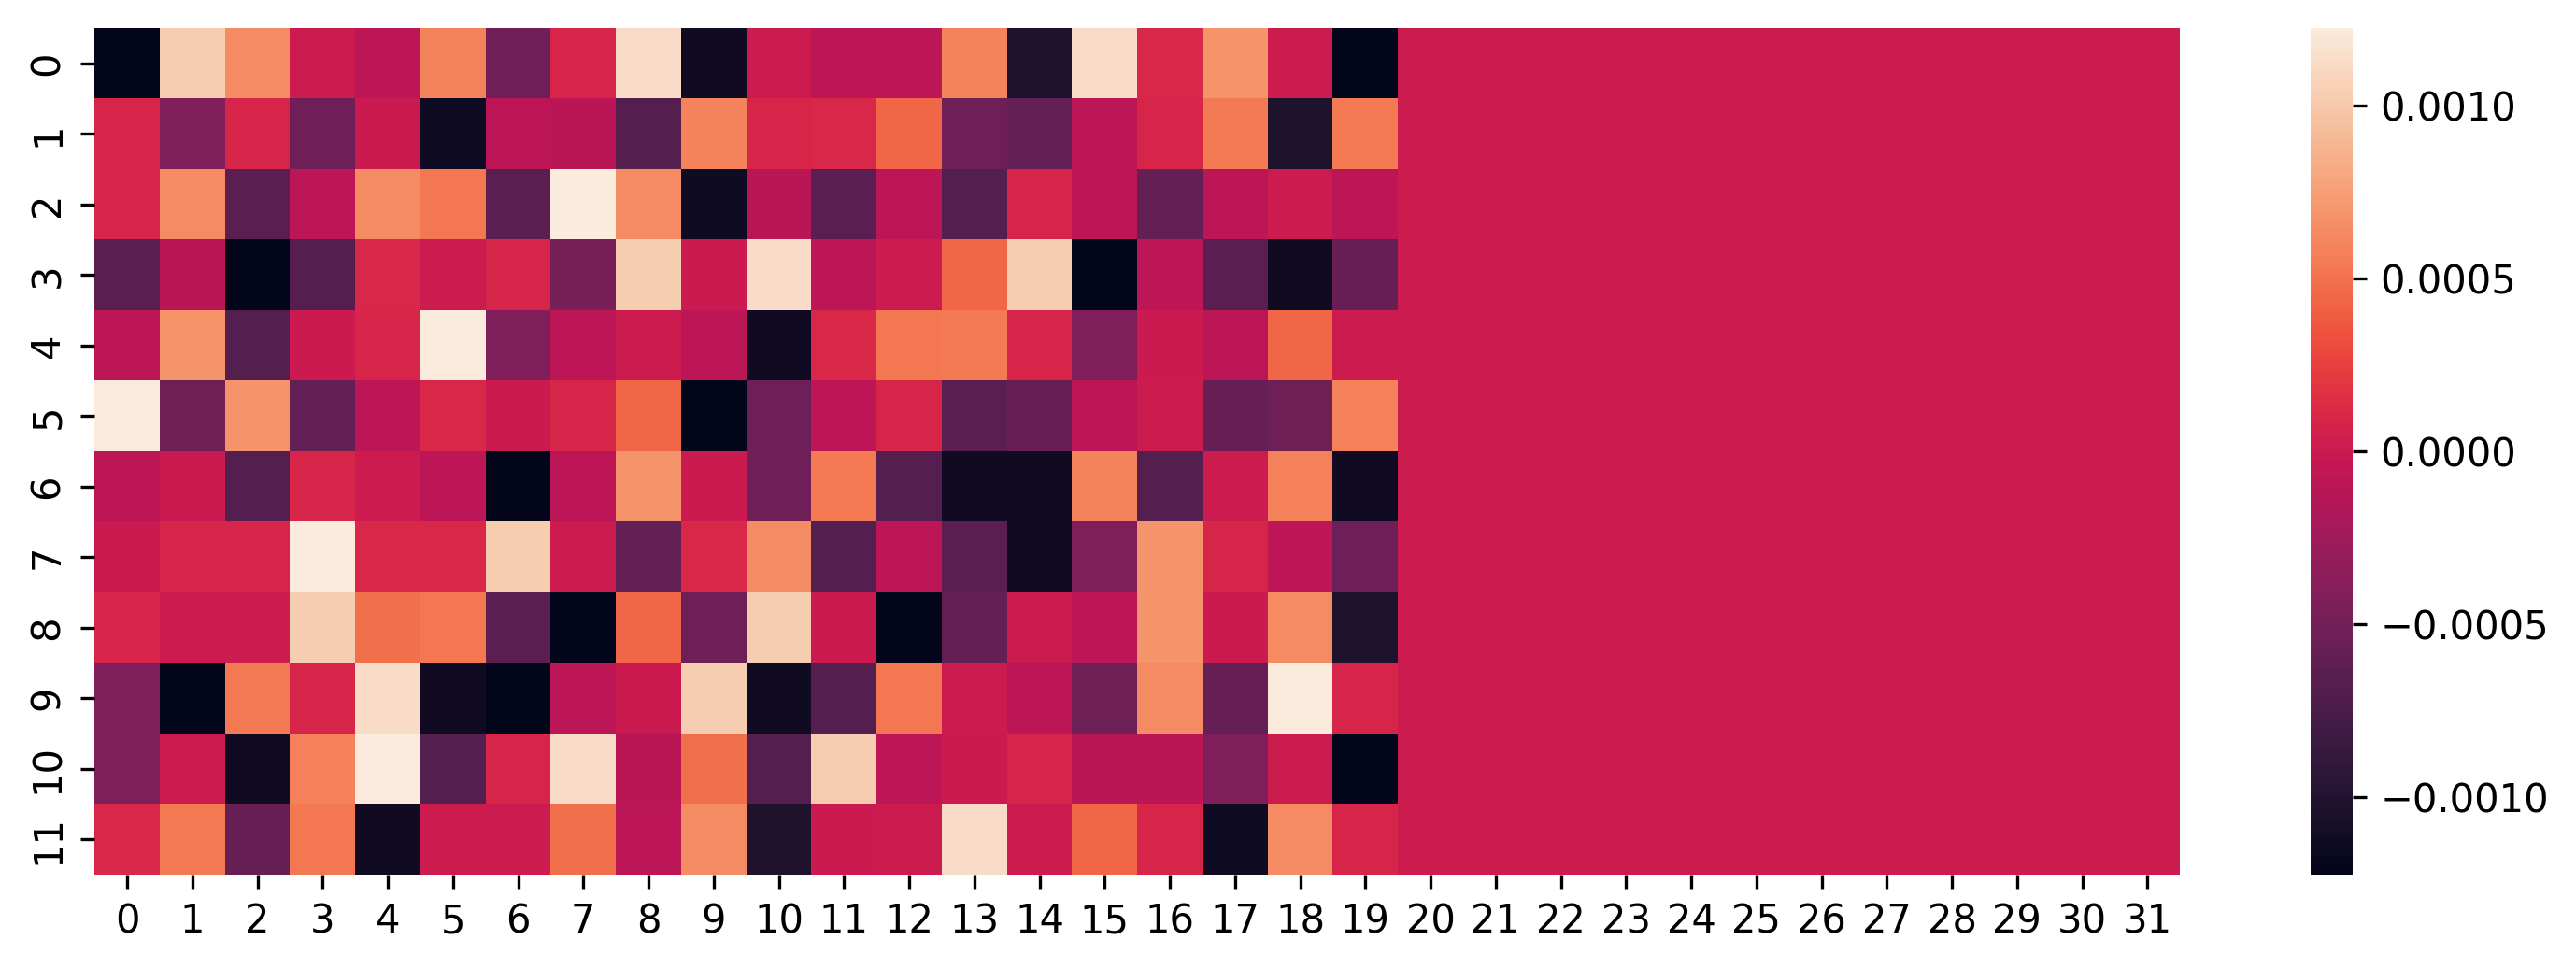

In [39]:
ax = sns.heatmap(mod_se2_reconstructed[0].weight - w_in_q[0])
plt.show()